In [1]:
import torch, torchvision
import torchvision.transforms as T
import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR100 test dataset
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[0.507, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2761]),
    ]
)
test_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load CIFAR100 pretrained model
model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet56-f2eff4c8.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet56-f2eff4c8.pt


  0%|          | 0.00/3.41M [00:00<?, ?B/s]

In [2]:
def check_accuracy(loader, model):
    """Check top 5 accuracy of a model on a given dataset"""
    model.to(DEVICE)
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm.tqdm(loader):
            scores = model(x.to(DEVICE))
            _, preds = scores.topk(5, 1, True, True)
            preds = preds.t()
            correct = preds.cpu().eq(y.view(1, -1).expand_as(preds))
            num_correct += correct[:5].reshape(-1).float().sum(0, keepdim=True)
            num_samples += x.shape[0]

        acc = float(num_correct) / num_samples
        return acc


# Check top 5 accuracy of the model on the test dataset
acc = check_accuracy(test_loader, model)
print(acc)


100%|██████████| 79/79 [00:10<00:00,  7.63it/s]

0.9194


In [3]:
# Prune the model and make experiments according to the assignment pdf
import torch.nn.utils.prune as prune
import numpy as np

##FILL HERE
def get_prunable_parameters(model, conv=True, linear=True):
    for name, module in model.named_modules():
        if conv and isinstance(module, torch.nn.Conv2d):
            yield (module, 'weight')
        elif linear and isinstance(module, torch.nn.Linear):
            yield (module, 'weight')
            yield (module, 'bias')

def get_pruned_model(pruner):
    model = torch.hub.load(
        "chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True
    )
    pruner(list(get_prunable_parameters(model)))
    return model

def global_ln_structured(params, amount, n, dim, **kwargs):
    for module, name in params:
        if isinstance(module, torch.nn.Linear):
            continue
        prune.ln_structured(module, name=name, amount=amount, n=n, dim=dim, **kwargs)

In [4]:
# Reference: https://leimao.github.io/blog/PyTorch-Pruning/

import os
import copy
import torch
import torch.nn.utils.prune as prune

def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 1e-6

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity


def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    num_zeros = 0
    num_elements = 1e-6

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 0.0% | Achieved Sparsity: 0.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 20.52it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 10.0% | Achieved Sparsity: 10.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.62it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 20.0% | Achieved Sparsity: 20.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.29it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 30.0% | Achieved Sparsity: 30.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 23.08it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 40.0% | Achieved Sparsity: 40.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.68it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 50.0% | Achieved Sparsity: 50.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.57it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 60.0% | Achieved Sparsity: 60.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.59it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 70.0% | Achieved Sparsity: 70.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 23.12it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 80.0% | Achieved Sparsity: 80.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.78it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 90.0% | Achieved Sparsity: 90.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.71it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 0.0% | Achieved Sparsity: 0.0% | Success? True


100%|██████████| 79/79 [00:04<00:00, 19.63it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 10.0% | Achieved Sparsity: 10.0% | Success? True


100%|██████████| 79/79 [00:04<00:00, 18.18it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 20.0% | Achieved Sparsity: 20.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.74it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 30.0% | Achieved Sparsity: 30.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 23.14it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 40.0% | Achieved Sparsity: 40.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.69it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 50.0% | Achieved Sparsity: 50.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.97it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 60.0% | Achieved Sparsity: 60.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.66it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 70.0% | Achieved Sparsity: 70.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.79it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 80.0% | Achieved Sparsity: 80.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 22.73it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 90.0% | Achieved Sparsity: 90.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 23.39it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 0.0% | Achieved Sparsity: 0.0% | Success? True


100%|██████████| 79/79 [00:03<00:00, 23.16it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 10.0% | Achieved Sparsity: 0.0% | Success? False


100%|██████████| 79/79 [00:03<00:00, 23.13it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 20.0% | Achieved Sparsity: 33.2% | Success? False


100%|██████████| 79/79 [00:03<00:00, 23.05it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 30.0% | Achieved Sparsity: 33.2% | Success? False


100%|██████████| 79/79 [00:03<00:00, 22.88it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 40.0% | Achieved Sparsity: 33.2% | Success? False


100%|██████████| 79/79 [00:03<00:00, 22.90it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 50.0% | Achieved Sparsity: 66.5% | Success? False


100%|██████████| 79/79 [00:03<00:00, 23.03it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 60.0% | Achieved Sparsity: 66.8% | Success? False


100%|██████████| 79/79 [00:03<00:00, 22.89it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 70.0% | Achieved Sparsity: 66.8% | Success? False


100%|██████████| 79/79 [00:03<00:00, 23.19it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 80.0% | Achieved Sparsity: 66.8% | Success? False


100%|██████████| 79/79 [00:03<00:00, 23.23it/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Desired Sparsity: 90.0% | Achieved Sparsity: 100.0% | Success? False


100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


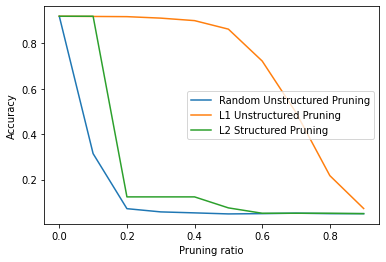

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for config in [
    {'name': 'Random Unstructured Pruning', 'pruner': lambda params, amount: prune.global_unstructured(params, pruning_method=prune.RandomUnstructured, amount=amount)},
    {'name': 'L1 Unstructured Pruning', 'pruner': lambda params, amount: prune.global_unstructured(params, pruning_method=prune.L1Unstructured, amount=amount)},
    {'name': 'L2 Structured Pruning', 'pruner': lambda params, amount: global_ln_structured(params, amount, n=2, dim=-1)},
]:
    amounts = np.arange(0, 1, 0.1)
    accuracies = []
    for amount in amounts:
        pruner = lambda params: config['pruner'](params, amount=amount)
        pruned_model = get_pruned_model(pruner)
        sparsity = measure_global_sparsity(pruned_model, conv2d_use_mask=True, linear_use_mask=True)[-1] 
        print(f"Desired Sparsity: {amount:.1%} | Achieved Sparsity: {sparsity:.1%} | Success? {np.isclose(amount, sparsity, atol=0.01)}")
        accuracies.append(check_accuracy(test_loader, pruned_model))

    plt.plot(amounts, accuracies, label=config['name'])

plt.xlabel("Pruning ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.show()